# Efficient Online Training with GRPO and vLLM in TRL

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we'll walk through how to post-train a Large Language Model (LLM) using **Group Relative Policy Optimization (GRPO)** with TRL, enhanced by **vLLM**. We already have a [previous recipe](https://huggingface.co/learn/cookbook/fine_tuning_llm_grpo_trl) focused on GRPO itself. In contrast, this notebook emphasizes **efficient online training with vLLM**.

Although we focus on GRPO here, the same setup applies to **any online training method in TRL** that requires generating completions during training, such as DPO. The key idea is to **leverage vLLM** to remove the generation bottleneck and significantly accelerate training.

Why does this matter? Online training methods rely on the model generating outputs in real time, which often becomes a critical speed and memory bottleneck. **vLLM** solves this with a high-throughput, low-latency inference engine built on **PagedAttention**, enabling faster generation and more efficient memory usage—making large-scale online training far more practical.

This notebook is designed for Colab, where we only have access to a single GPU. We'll demonstrate how to run both TRL and vLLM on the same GPU efficiently. With more GPUs, this approach can scale seamlessly: TRL allows you to dedicate separate GPUs for training and vLLM, further boosting performance.

As you'll see, with only a few adjustments, we can directly observe a measurable gain in training efficiency.

The diagram below illustrates the overall training workflow and highlights where vLLM (blue box) and TRL (pink box) fit into the process:

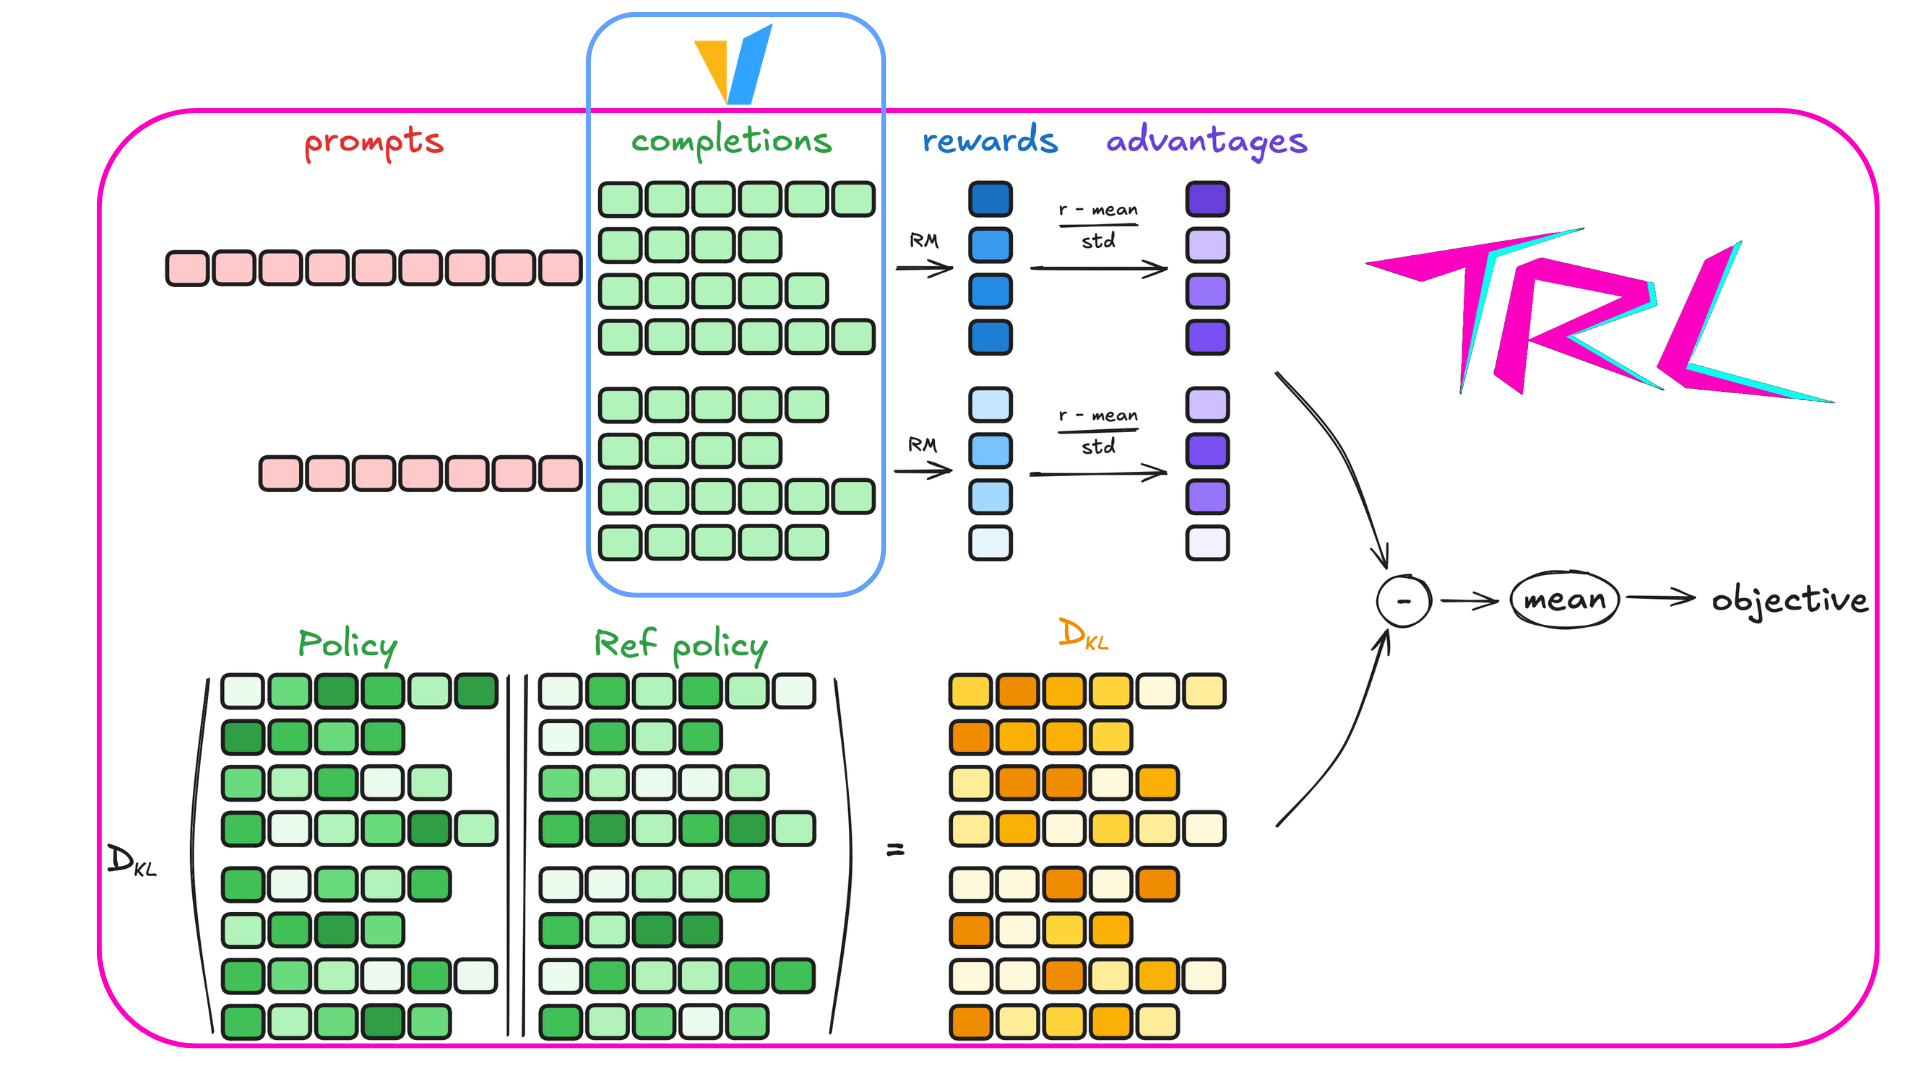

## 1. Install Dependencies

First, let's install the essential libraries required for fine-tuning.
The important highlight here is **TRL with vLLM support**, which enables **high-throughput, low-latency generation** during online training, removing the common bottleneck in completion generation.

In [1]:
!pip install -U -q trl[vllm] peft math_verify trackio

# Tested with trl==0.23.0, peft==0.17.1, math_verify==0.8.0, vllm==0.10.2, trackio==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.9/207.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.4/864.4 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.

Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load Dataset 📁

These models excel at tasks that require **complex, multi-step reasoning**.
A prime example is **mathematical problem-solving**, where step-by-step thinking is essential to arrive at the correct answer.

For this project, we'll use the [AI-MO/NuminaMath-TIR](https://huggingface.co/datasets/AI-MO/NuminaMath-TIR) dataset.  
This **reasoning-focused dataset** contains mathematical problems, their final solutions, and, most importantly, **detailed reasoning steps** that explain how to move from the problem statement to the solution.


In [3]:
from datasets import load_dataset

dataset_id = 'AI-MO/NuminaMath-TIR'
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'test[:10%]'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/215k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/72441 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/99 [00:00<?, ? examples/s]

Let's check the structure of the dataset

In [4]:
print(train_dataset)

Dataset({
    features: ['problem', 'solution', 'messages'],
    num_rows: 7244
})


Let's check one sample:

In [5]:
print(train_dataset[0])

{'problem': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.', 'solution': "To determine the coefficient of \\(x^2y^6\\) in the expansion of \\(\\left(\\frac{3}{5}x - \\frac{y}{2}\\right)^8\\), we can use the binomial theorem.\n\nThe binomial theorem states:\n\\[\n(a + b)^n = \\sum_{k=0}^{n} \\binom{n}{k} a^{n-k} b^k\n\\]\n\nIn this case, \\(a = \\frac{3}{5}x\\), \\(b = -\\frac{y}{2}\\), and \\(n = 8\\).\n\nWe are interested in the term that contains \\(x^2y^6\\). In the general term of the binomial expansion:\n\\[\n\\binom{8}{k} \\left(\\frac{3}{5}x\\right)^{8-k} \\left(-\\frac{y}{2}\\right)^k\n\\]\n\nTo get \\(x^2\\), we need \\(8 - k = 2\\), thus \\(k = 6\\).\n\nSubstituting \\(k = 6\\) into the expression:\n\\[\n\\binom{8}{6} \\left(\\frac{3}{5}x\\right)^{8-6} \\left(-\\frac{y}{2}\\right)^6 = \\binom{8}{6} \\left(\\frac{3}{5}x\\right)^2 \\left(-\\frac{y}{2}\\right)^6\n\\]\n\nNow, we wi

In the **DeepSeek-R1** training procedure (where GRPO was first introduced, as described in the [previous notebook](https://huggingface.co/learn/cookbook/fine_tuning_llm_grpo_trl)), a specific **system prompt** was used to guide the model in generating both **reasoning steps** and the **final answer** in a structured format.

We'll adopt the same approach here, formatting our dataset so that each example represents a **conversation between a User and an Assistant**. The Assistant is prompted to first think through the problem before providing the final solution.

The system prompt used is:

```
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>. User: prompt. Assistant:
```

This conversational structure ensures that the model **explicitly demonstrates its reasoning** before giving the answer, which is crucial for enhancing multi-step reasoning skills in mathematical problem-solving tasks.

In [6]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)

def make_conversation(example):
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": example["problem"]},
        ],
    }

train_dataset = train_dataset.map(make_conversation)
test_dataset = test_dataset.map(make_conversation)

Map:   0%|          | 0/7244 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's take a look at an example:

In [7]:
print(train_dataset[0]['prompt'])

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>', 'role': 'system'}, {'content': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.', 'role': 'user'}]


We'll remove the `messages` and `problem` columns, as we only need the custom `prompt` column and `solution` to verify the generated answer.

In [8]:
train_dataset = train_dataset.remove_columns(['messages', 'problem'])
print(train_dataset)

Dataset({
    features: ['solution', 'prompt'],
    num_rows: 7244
})


## 3. Post-Training the Base Model Using GRPO + vLLM ⚡

The diagram below highlights the main differences between **PPO** (Proximal Policy Optimization) and **GRPO** (Group Relative Policy Optimization), particularly the removal of the value model in GRPO.

A key challenge in online methods like GRPO is that the model must generate completions during training, which can quickly become a bottleneck. By integrating **vLLM**, we enable **high-throughput, low-latency generation** via its [**PagedAttention**](https://blog.vllm.ai/2023/06/20/vllm.html) mechanism. This not only speeds up the post-training loop but also improves memory efficiency, making large-scale reasoning tasks more practical.

TRL supports online training with vLLM in two different modes:

- **`colocate`**: The trainer process and the vLLM process share the same GPU resources. This is the setup used in this notebook, since Colab provides only a single GPU.
- **`server`**: The trainer and vLLM run on separate GPUs. This mode is ideal for multi-GPU setups, where TRL can use some GPUs for training while vLLM uses others, communicating via HTTP.

These modes provide flexibility to efficiently leverage available hardware while benefiting from vLLM's fast generation.

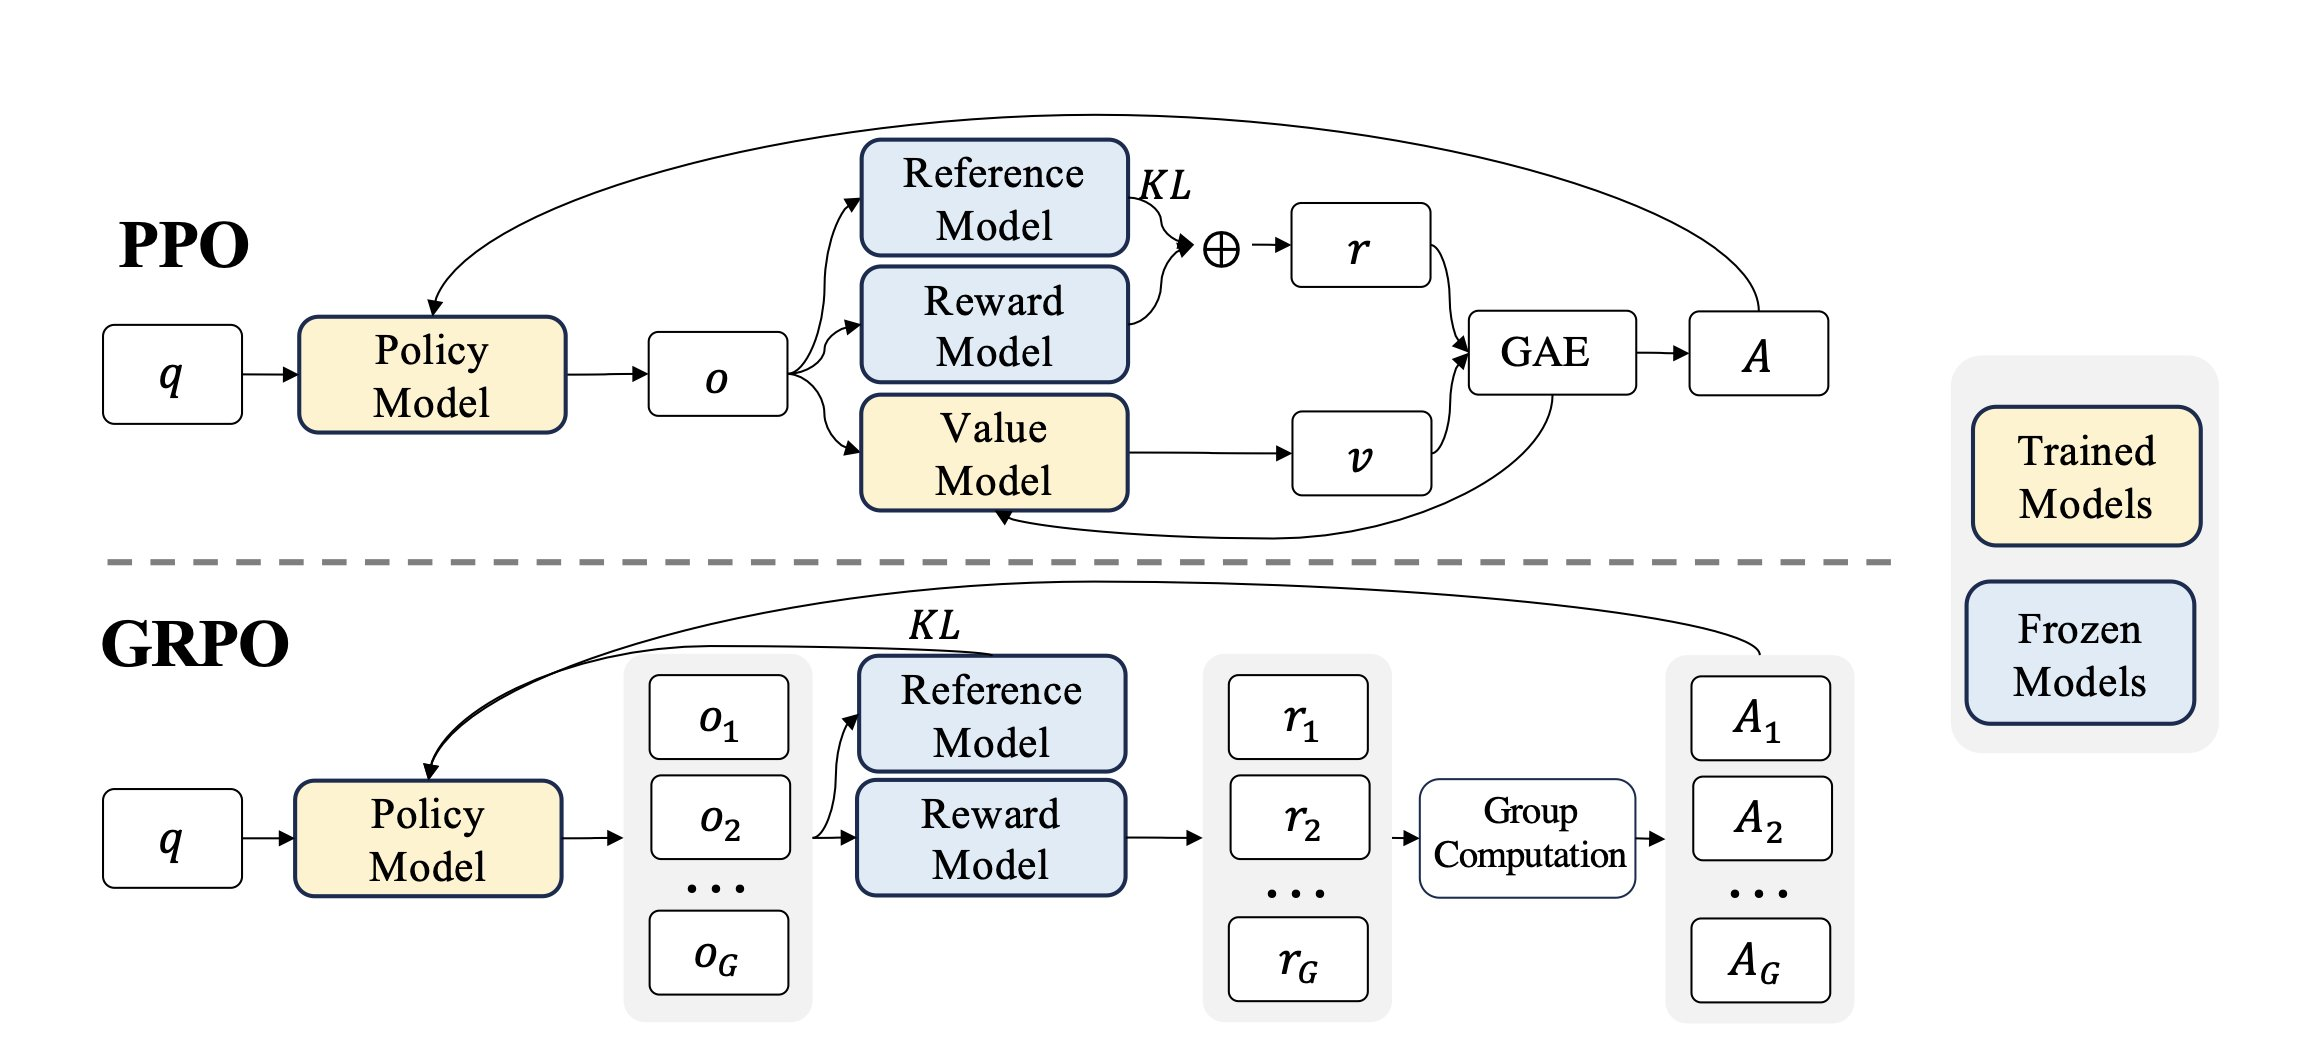

### 3.1 Loading the Baseline Model

We'll start by loading [Qwen/Qwen2-0.5B](https://huggingface.co/Qwen/Qwen2.5-0.5B) as our baseline (the **Policy Model** in the diagram above).  
With just **0.5B parameters**, this model is lightweight and fits comfortably within typical GPU memory.  

- For improved performance, you may consider a [larger alternative model](https://x.com/jiayi_pirate/status/1882839487417561307).  
- We intentionally avoid the newer **Qwen2.5** or **Qwen3** series, since they are already optimized for reasoning/maths tasks, as also [highlighted by other developers](https://thinkingmachines.ai/blog/lora/#reinforcement-learning).

Later in the workflow, **vLLM will reuse this same model for generation**. Importantly, we **don't need to initialize vLLM here**—TRL will handle initialization automatically once the training loop begins, thanks to **colocate mode** (explained earlier).  

We'll see how this comes into play in the next steps.

In [9]:
import torch
from transformers import AutoModelForCausalLM

model_id = "Qwen/Qwen2-0.5B-Instruct" # "Qwen/Qwen2.5-0.5B"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype="auto",
    device_map="auto",
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

### 3.2 Configuring LoRA ⚙️

Next, we'll configure **LoRA** (Low-Rank Adaptation) for model training.  
LoRA allows us to **fine-tune the model efficiently** by updating a small set of parameters instead of the full model, resulting in **faster training** and **lower GPU memory usage**.

In [10]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


### 3.3 Loading Reward Functions

For the reward component of the system, we can use either pretrained reward models or reward functions defined directly in code. For training, the DeepSeek-R1 authors used an accuracy-based reward model evaluates whether the response is correct, alongside a format-based reward that ensures the model places its reasoning process between `<think> </think>` tags. You can find more details [here](https://github.com/huggingface/open-r1/blob/main/src/open_r1/grpo.py). We can simply define and implement these reward functions as generic Python functions.

In this case, we will utilize these reward functions:

1. **Format Enforcement:** Ensures that the generation follows a specific format using `<think> </think> <answer> </answer>` tags for reasoning.

In [11]:
import re
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    completion_contents = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, content) for content in completion_contents]
    rewards_list = [1.0 if match else 0.0 for match in matches]
    return [1.0 if match else 0.0 for match in matches]

2. **Solution Accuracy:** Verifies whether the solution to the problem is correct.

In [12]:
from math_verify import LatexExtractionConfig, parse, verify
def accuracy_reward(completions, **kwargs):
    """Reward function that checks if the completion is the same as the ground truth."""
    solutions = kwargs['solution']
    completion_contents = [completion[0]["content"] for completion in completions]
    rewards = []
    for content, solution in zip(completion_contents, solutions):
        gold_parsed = parse(solution, extraction_mode="first_match", extraction_config=[LatexExtractionConfig()])
        answer_parsed = parse(content, extraction_mode="first_match", extraction_config=[LatexExtractionConfig()])
        if len(gold_parsed) != 0:
            try:
                rewards.append(float(verify(answer_parsed, gold_parsed)))
            except Exception:
                rewards.append(0.0)
        else:
            rewards.append(1.0)
    return rewards

### 3.4 Configuring GRPO Training Parameters

Next, we'll configure the training parameters for GRPO. Key parameters to experiment with are `max_completion_length`, `num_generations`, and `max_prompt_length` (see the diagram at the beginning for details on each).  

To keep things simple, we'll start with **just one training epoch**. We've doubled the `max_completion_length` so the model can generate slightly longer answers than the default in the `GRPOConfig` of 256 tokens. In practice, we recommend setting `num_generations` to 8 or more, as this has virtually no impact on GPU memory. The same principle applies to other parameters—careful experimentation and fine-tuning are key to identifying the most effective configuration for your task. In the next section, we provide a table showing training speeds for different parameter settings.

We'll also enable **vLLM** for generation during training. This is done by setting `use_vllm=True`, which instructs TRL to automatically launch and manage vLLM once the training loop begins.

Since this notebook runs on **a single GPU**, we configure **`colocate` mode** (via the `vllm_mode` parameter), so both the trainer and vLLM share the same GPU resources. In multi-GPU setups, you can instead run vLLM in a separate process, dedicating specific GPUs to each and letting them communicate via HTTP—unlocking even greater efficiency.

For more advanced configurations, check out the [official vLLM integration guide](https://huggingface.co/docs/trl/main/en/vllm_integration). In multi-GPU environments, you can also launch vLLM with the `trl vllm-serve` tool to further maximize throughput and performance.

In [13]:
from trl import GRPOConfig

# Configure training arguments using GRPOConfig
training_args = GRPOConfig(
    output_dir="Qwen2-0.5B-GRPO-vllm-trl",
    learning_rate=1e-5,
    remove_unused_columns=False, # to access the solution column in accuracy_reward
    gradient_accumulation_steps=16,
    num_train_epochs=1,
    bf16=True,

    # Parameters that control de data preprocessing
    max_completion_length=512,  # default: 256
    num_generations=8,  # default: 8
    max_prompt_length=512,  # default: 512

    # Parameters related to reporting and saving
    report_to=["trackio"],
    logging_steps=10,
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,

    # Configure vLLM
    use_vllm=True,
    vllm_mode="colocate",
    # Some more params you can configure for vLLM with their defaults
    # vllm_model_impl='vllm',
    # vllm_enable_sleep_mode=False,
    # vllm_guided_decoding_regex=None,
    # vllm_server_base_url=None,
    # vllm_server_host='0.0.0.0',
    # vllm_server_port=8000,
    # vllm_server_timeout=240.0,
    # vllm_gpu_memory_utilization=0.3,
    # vllm_tensor_parallel_size=1
    # vllm_importance_sampling_correction=True,
    # vllm_importance_sampling_cap=2.0
)

### 3.5 Training the Model 🏃

Next, we'll configure the trainer and begin training the model.

For this setup, we pass the two reward functions we defined earlier to the trainer to guide the learning process.

Below is a diagram illustrating the training procedure we'll be reproducing, adapted from the [Open-R1 project](https://github.com/huggingface/open-r1).

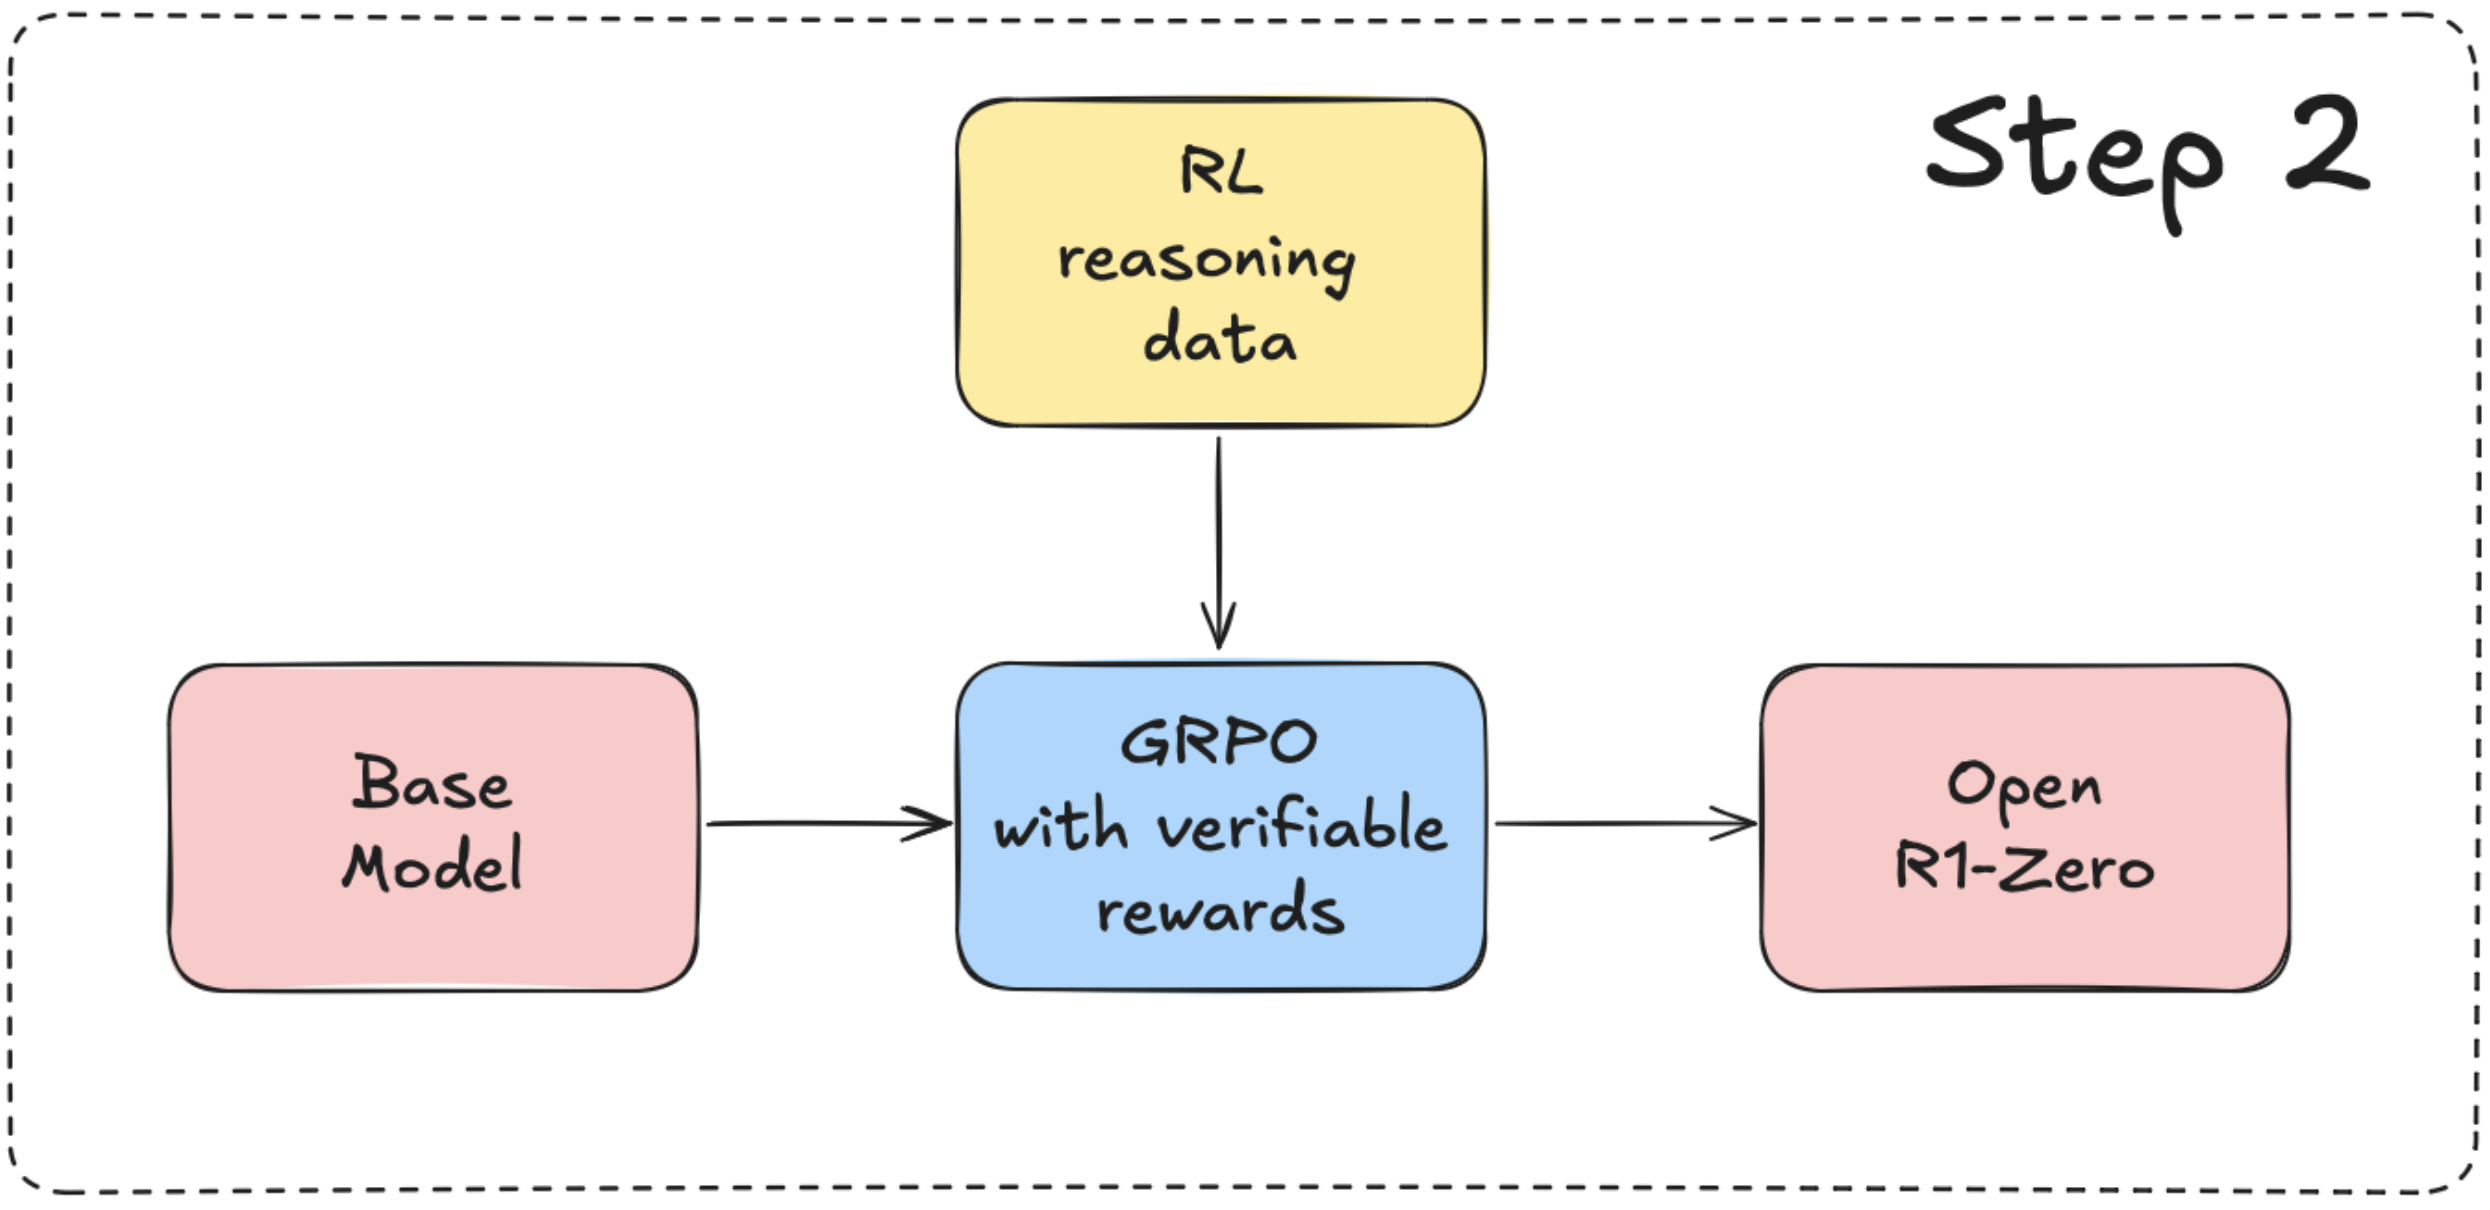

Finally, let’s configure the `GRPOTrainer`.

If you look closely at the output, you'll see details about the launch of vLLM. Thanks to TRL, integrating vLLM is straightforward, with minimal friction—allowing you to easily take advantage of high-throughput generation during online training.

For a deeper understanding of the benefits, we recommend comparing this notebook with the previous GRPO recipe without vLLM.

In [14]:
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    reward_funcs=[format_reward, accuracy_reward],
    args=training_args,
    train_dataset=train_dataset
)

INFO 10-03 11:31:13 [__init__.py:216] Automatically detected platform cuda.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

INFO 10-03 11:31:25 [utils.py:328] non-default args: {'seed': 0, 'max_model_len': 1024, 'distributed_executor_backend': 'external_launcher', 'gpu_memory_utilization': 0.3, 'max_num_batched_tokens': 4096, 'max_num_seqs': 128, 'disable_log_stats': True, 'model_impl': 'vllm', 'model': 'Qwen/Qwen2-0.5B-Instruct'}
INFO 10-03 11:31:43 [__init__.py:742] Resolved architecture: Qwen2ForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 10-03 11:31:43 [__init__.py:1815] Using max model len 1024
INFO 10-03 11:31:43 [parallel.py:348] Disabling V1 multiprocessing for external launcher.
INFO 10-03 11:31:43 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=4096.
INFO 10-03 11:31:44 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='Qwen/Qwen2-0.5B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-0.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=1024, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=Observ

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-03 11:31:49 [default_loader.py:268] Loading weights took 0.38 seconds
INFO 10-03 11:31:50 [gpu_model_runner.py:2392] Model loading took 0.9280 GiB and 1.456525 seconds
INFO 10-03 11:31:57 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/6b5707004a/rank_0_0/backbone for vLLM's torch.compile
INFO 10-03 11:31:57 [backends.py:550] Dynamo bytecode transform time: 6.18 s
INFO 10-03 11:32:01 [backends.py:194] Cache the graph for dynamic shape for later use
INFO 10-03 11:32:18 [backends.py:215] Compiling a graph for dynamic shape takes 20.69 s
INFO 10-03 11:32:19 [monitor.py:34] torch.compile takes 26.87 s in total
INFO 10-03 11:32:21 [gpu_worker.py:298] Available KV cache memory: 22.15 GiB
INFO 10-03 11:32:22 [kv_cache_utils.py:864] GPU KV cache size: 1,935,168 tokens
INFO 10-03 11:32:22 [kv_cache_utils.py:868] Maximum concurrency for 1,024 tokens per request: 1889.81x


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:01<00:00, 25.35it/s]


INFO 10-03 11:32:25 [gpu_model_runner.py:3118] Graph capturing finished in 3 secs, took 0.23 GiB
INFO 10-03 11:32:25 [gpu_worker.py:391] Free memory on device (77.9/79.32 GiB) on startup. Desired GPU memory utilization is (0.3, 23.8 GiB). Actual usage is 0.93 GiB for weight, 0.7 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.23 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=23376844595` to fit into requested memory, or `--kv-cache-memory=81467253760` to fully utilize gpu memory. Current kv cache memory in use is 23779497779 bytes.
INFO 10-03 11:32:25 [core.py:218] init engine (profile, create kv cache, warmup model) took 34.63 seconds
INFO 10-03 11:32:26 [llm.py:295] Supported_tasks: ('generate',)
INFO 10-03 11:32:26 [__init__.py:36] No IOProcessor plugins requested by the model


Time to train the model! 🎉

In [15]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


* Running on public URL: https://9ac0965de56f037c3a.gradio.live
* Trackio project initialized: huggingface
* Trackio metrics logged to: /root/.cache/huggingface/trackio


* Created new run: dainty-sunset-0
INFO 10-03 11:32:29 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,0.080900
20,0.128500
30,0.209800
40,0.281500
50,0.395200
60,0.297500
70,0.294200
80,0.246800
90,0.205800
100,0.171900


INFO 10-03 11:32:44 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:32:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:33:12 [block_pool.py:292] Successfully reset prefix cache


INFO 10-03 11:33:33 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:33:47 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:34:00 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:34:13 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:34:41 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:34:54 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:35:08 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:35:22 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:35:38 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:35:50 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:36:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:36:17 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:36:30 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:36:43 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:36:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:37:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:37:23 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:37:35 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:37:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:38:01 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:38:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:38:28 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:38:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:38:56 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:39:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:39:22 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:39:35 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:39:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:40:03 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:40:15 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:40:28 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:40:40 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:40:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:41:06 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:41:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:41:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:41:44 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:41:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:42:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:42:22 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:42:34 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:42:47 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:42:59 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:43:11 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:43:24 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:43:36 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:43:48 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:44:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:44:23 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:44:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:44:41 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:44:52 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:45:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:45:12 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/sympy/solvers/solvers.py:950: SymPyDeprecationWarning: 

Using non-Expr arguments in Add is deprecated (in this case, one of
the arguments has type 'Tuple').

If you really did intend to use a multiplication or addition operation with
this object, use the * or + operator instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#non-expr-args-deprecated
for details.

This has been deprecated since SymPy version 1.7. It
will be removed in a future version of SymPy.

  fi = Add(fi.lhs, -fi.rhs, evaluate=False)


INFO 10-03 11:45:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:45:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:45:50 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:46:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:46:13 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:46:22 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:46:30 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:46:41 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:46:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:47:03 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:47:15 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:47:26 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:47:35 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:47:45 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:47:54 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:01 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:12 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:30 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:46 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:48:54 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:49:01 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:49:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:49:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:49:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:49:39 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:49:45 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:49:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:50:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:50:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:50:30 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:50:37 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:50:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:50:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:07 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:18 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:46 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:51:52 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:04 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:52:11 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:16 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:23 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:49 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:52:56 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:18 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:53:27 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:39 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:45 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:50 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:53:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:16 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:21 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:29 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:54:35 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:41 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:54:47 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:01 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:21 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:29 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:46 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:55:51 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:55:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:12 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:43 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:56:50 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:56:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:27 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:34 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:39 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:44 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:57:52 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:57:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:58:03 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

INFO 10-03 11:59:13 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 11:59:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:59:27 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:59:35 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:59:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:59:47 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:59:52 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 11:59:58 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:00:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:00:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:00:19 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:00:24 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:00:36 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:00:42 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:00:49 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:00:54 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:01 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:11 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:17 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:22 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:29 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:35 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:44 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:50 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:01:55 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:01 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:09 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:18 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

INFO 10-03 12:02:29 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:35 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:45 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:52 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:02:57 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:03 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:08 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:20 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:25 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:38 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:44 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:50 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:03:56 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:01 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:09 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:14 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:20 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:26 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

INFO 10-03 12:04:37 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:46 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:52 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:04:58 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:03 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:11 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:16 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:21 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:32 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:37 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:50 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:05:59 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:06:07 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:06:18 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:06:29 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:06:42 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:06:53 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:07:00 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:07:07 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:07:12 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:07:23 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:07:36 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:07:41 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:07:46 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:07:52 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:03 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:13 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:24 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:37 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:08:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:08:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:09:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:09:13 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:09:19 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:09:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:09:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:09:44 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:09:51 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:03 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:10:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:15 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:26 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:49 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:10:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:11:00 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:11:06 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:11:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:11:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:11:26 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:11:34 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:11:40 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:11:45 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:11:52 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:11:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:12:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:12:22 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:12:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:12:39 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:12:51 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:12:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:15 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:26 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:32 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:13:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:43 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:49 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:13:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:27 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:39 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:14:44 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:49 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:14:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:01 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:11 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:16 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:22 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:28 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:34 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:41 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:15:46 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:52 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:15:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:05 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:11 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:20 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:30 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:35 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:42 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:16:52 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:16:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:17:03 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:17:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:17:13 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:17:18 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:17:29 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:17:41 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:17:55 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:18:03 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:18:09 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:18:14 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:18:20 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:18:26 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:18:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:18:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:18:47 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:18:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:18:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:04 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:19:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:15 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:22 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:27 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:43 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:19:54 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:00 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:20:05 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:16 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:22 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:27 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:33 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:44 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:20:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:21:03 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:21:09 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:21:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:21:19 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:21:25 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:21:32 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:21:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:21:51 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:21:56 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:08 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:22:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:24 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:22:29 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:37 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:22:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:01 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:07 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:13 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:23:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:36 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:41 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:23:58 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:12 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:24:17 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:23 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:29 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:35 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:40 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:24:59 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:04 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:12 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:25:24 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:36 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:43 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:51 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:25:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:07 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:20 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:26:25 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:26:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:36 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:44 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:49 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:26:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:00 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:05 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:17 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:27:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:38 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:49 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:27:55 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:01 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:15 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:21 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:34 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:40 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:28:45 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:28:54 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:29:05 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:29:10 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:29:15 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:29:22 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:29:27 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:29:41 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:29:46 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:29:54 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:30:00 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:06 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:13 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:18 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:23 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:29 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:34 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:40 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:45 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:30:52 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:30:57 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:02 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:08 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:14 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:26 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:31:54 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:00 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:32:05 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:11 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:19 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:25 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:31 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:36 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:42 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:48 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:53 [block_pool.py:292] Successfully reset prefix cache
INFO 10-03 12:32:59 [block_pool.py:292] Successfully reset prefix cache


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO 10-03 12:33:04 [block_pool.py:292] Successfully reset prefix cache
* Run finished. Uploading logs to Trackio (please wait...)


TrainOutput(global_step=452, training_loss=0.09777604969140076, metrics={'train_runtime': 3645.3922, 'train_samples_per_second': 1.987, 'train_steps_per_second': 0.124, 'total_flos': 0.0, 'train_loss': 0.09777604969140076})

Let's save the results 💾

In [16]:
trainer.save_model(training_args.output_dir)
trainer.push_to_hub(dataset_name=dataset_id)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...llm-trl/training_args.bin: 100%|##########| 7.18kB / 7.18kB            

  ...adapter_model.safetensors: 100%|##########| 2.18MB / 2.18MB            

  ...O-vllm-trl/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...llm-trl/training_args.bin: 100%|##########| 7.18kB / 7.18kB            

  ...adapter_model.safetensors: 100%|##########| 2.18MB / 2.18MB            

  ...O-vllm-trl/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

CommitInfo(commit_url='https://huggingface.co/sergiopaniego/Qwen2-0.5B-GRPO-vllm-trl/commit/9673308cb68be4731350096fade0a79cda77dcf5', commit_message='End of training', commit_description='', oid='9673308cb68be4731350096fade0a79cda77dcf5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergiopaniego/Qwen2-0.5B-GRPO-vllm-trl', endpoint='https://huggingface.co', repo_type='model', repo_id='sergiopaniego/Qwen2-0.5B-GRPO-vllm-trl'), pr_revision=None, pr_num=None)

Below, you can review the `trackio` results for the training. They look promising!

The setup shown here runs on a single GPU, yet we can already see how vLLM boosts training efficiency. With vLLM enabled, training reaches **0.07 it/s**, whereas disabling it (`use_vllm=False`) drops performance to **0.04 it/s**—an immediate **~75% speedup** even in this basic configuration.  

And this is just the beginning: we haven't yet explored more optimal setups. For further efficiency gains, you can experiment with training parameters like `max_completion_length`, `num_generations`, or `max_prompt_length`, and scale across multiple GPUs to fully leverage vLLM's high-throughput generation.

## 4. Evaluating Different Training Configurations

After training a model efficiently with a single configuration, it's insightful to explore other possible configurations to understand how training performance changes when using vLLM versus not using it. The table below shows various configurations along with their corresponding `it/s` (iterations per second), highlighting the performance impact of vLLM.  

These results were obtained using a Colab setup, so you can expect significantly higher gains when scaling to more advanced environments with multiple GPUs or distributed nodes.


| `max_completion_length` | `num_generations` | `max_prompt_length` | `vLLM` | `it/s` |
|----------------------|----------------|-----------------|------|------|
| 64                  | 4             | 128             | ✅    |    0.14  |
| 64                  | 4             | 128             | ❌    |    0.12  |
| 64                  | 8            | 128             | ✅    |    0.14  |
| 64                  | 8             | 128             | ❌    |  0.12    |
| 128                  | 8              | 128             | ✅    |   0.13   |
| 128                  | 8              | 128             | ❌    |   0.09   |
| 128                  | 16             | 128             | ✅    |  0.13    |
| 128                  | 16             | 128             | ❌    |   0.09   |
| 256                  | 8              | 128             | ✅    |   0.10   |
| 256                  | 8              | 128             | ❌    |   0.06   |
| 256                  | 16             | 128             | ✅    |  0.10    |
| 256                  | 16             | 128             | ❌    |   0.06   |
| 512                  | 8              | 128             | ✅    |  0.07    |
| 512                  | 8              | 128             | ❌    |  0.04    |
| 512                  | 16             | 128             | ✅    |   0.07   |
| 512                  | 16             | 128             | ❌    |   0.04   |
| 1024                  | 16             | 128             | ✅    |   0.04   |
| 1024                  | 16             | 128             | ❌    |   0.02   |
| 1024                  | 32              | 128             | ✅    |  0.04    |
| 1024                  | 32              | 128             | ❌    |  0.02    |

From the table above, several observations can be made:

- As `max_completion_length` increases, the `it/s` naturally decreases, which is expected due to the larger computation per iteration.  
- vLLM consistently provides faster training, and the performance gain becomes more significant as we scale to larger `max_completion_length` values.  
- The `num_generations` parameter has minimal impact on `it/s`, showing that parallel generation does not significantly affect throughput in this setup.  
- Although `max_prompt_length` was kept constant in these experiments, similar trends would apply if it were increased: higher values would reduce `it/s` depending on the dataset characteristics, just like `max_completion_length`.


## 5. Check the Model Performance

We've kept things simple so far, but now let's check if the model has already learned to reason. We'll load the saved model and run an evaluation on a test sample.

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "sergiopaniego/Qwen2-0.5B-GRPO-vllm-trl"
trained_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(model_id)

adapter_config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/973 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/328 [00:00<?, ?B/s]

Let's check one sample from the test set!

In [18]:
print(test_dataset['prompt'][0])

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>', 'role': 'system'}, {'content': "In 1988, a person's age was equal to the sum of the digits of their birth year. How old was this person?", 'role': 'user'}]


We'll create a function to interact with the model. In addition to generating the answer, we'll measure the inference duration and count the number of generated tokens. This will give us insights into how much the model has reasoned during generation.

In [19]:
import time
import torch

def generate_with_reasoning(prompt):
  # Build the prompt from the dataset
  prompt = " ".join(entry['content'] for entry in prompt)

  # Tokenize and move to the same device as the model
  inputs = trained_tokenizer(prompt, return_tensors="pt").to(trained_model.device)

  # Generate text without gradients
  start_time = time.time()
  with torch.no_grad():
      output_ids = trained_model.generate(**inputs, max_length=500)
  end_time = time.time()

  # Decode and extract model response
  generated_text = trained_tokenizer.decode(output_ids[0], skip_special_tokens=True)

  # Get inference time
  inference_duration = end_time - start_time

  # Get number of generated tokens
  num_input_tokens = inputs['input_ids'].shape[1]
  num_generated_tokens = output_ids.shape[1] - num_input_tokens

  return generated_text, inference_duration, num_generated_tokens

Let's generate the answer for that test sample!

In [44]:
prompt = test_dataset['prompt'][0]
generated_text, inference_duration, num_generated_tokens = generate_with_reasoning(prompt)
print(generated_text)

A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer> In 1988, a person's age was equal to the sum of the digits of their birth year. How old was this person?< think > Reasoning process: Let's assume that the person's birth year is x. Then the age would be y = x + (x/10). We know that the age is equal to the sum of the digits of the birth year, so we can write y = 10y. Solving for y, we get y = 10x - 10, or y = x/3. Since the age must be an integer, we need to find the smallest integer value for x such that x/3 is greater than or equal to 1988. So, we have x = 1988 * 3 = 5964. Substituting this into our equation for y, we get y = 5964/3 = 1928. The

The model already demonstrates the ability to generate the correct `<think>` and `<answer>` tags, even though the solution itself is incorrect.

Given the inference time and the number of generated tokens, this approach shows potential benefits:

In [45]:
print(f"Inference time: {inference_duration:.2f} seconds")
print(f"Generated tokens: {num_generated_tokens}")

Inference time: 7.71 seconds
Generated tokens: 208


Let's review the generated response to better visualize this behavior:

In [46]:
prompt_text = " ".join(entry['content'] for entry in prompt)
response_text = generated_text[len(prompt_text):].strip()
print(response_text)

< think > Reasoning process: Let's assume that the person's birth year is x. Then the age would be y = x + (x/10). We know that the age is equal to the sum of the digits of the birth year, so we can write y = 10y. Solving for y, we get y = 10x - 10, or y = x/3. Since the age must be an integer, we need to find the smallest integer value for x such that x/3 is greater than or equal to 1988. So, we have x = 1988 * 3 = 5964. Substituting this into our equation for y, we get y = 5964/3 = 1928. Therefore, this person's age was 1928 years old. < think > answer </think> <answer>1928</answer> </answer>


We observe that the model shows some reasoning capabilities, although they are quite limited. This is likely due to using a small model and a very basic training setup, designed more for educational purposes than for maximizing performance.  

For better results, using a larger model, training on the full dataset, and adjusting the configuration to generate more and longer completions would significantly improve the model's final performance.

## 5. Continuing Your Learning Journey 🧑‍🎓

This notebook is just the beginning of exploring **online training methods** with TRL, including **GRPO** and other online trainers, now enhanced with **vLLM** for faster, more efficient generation.  

If you’re eager to dive deeper, check out the resources linked throughout this notebook, as well as the following materials:

- [vLLM Documentation](https://docs.vllm.ai/en/latest/)  
- [TRL vLLM Integration Guide](https://huggingface.co/docs/trl/main/en/vllm_integration)  
- [DeepSeek-R1 Repository](https://github.com/deepseek-ai/DeepSeek-R1/)  
- [DeepSeek-R1 Paper](https://github.com/deepseek-ai/DeepSeek-R1/blob/main/DeepSeek_R1.pdf)  
- [Open Reproduction of DeepSeek-R1](https://github.com/huggingface/open-r1/)  
- [GRPO TRL Trainer Documentation](https://huggingface.co/docs/trl/main/en/grpo_trainer)  
- [Phil Schmid's DeepSeek-R1 Blog Post](https://www.philschmid.de/deepseek-r1)  
- [Phil Schmid's Mini DeepSeek-R1 Blog Post](https://www.philschmid.de/mini-deepseek-r1)  
- [Illustrated DeepSeek-R1](https://newsletter.languagemodels.co/p/the-illustrated-deepseek-r1)  
- [The LM Book: DeepSeek-R1 Article](https://thelmbook.com/articles/#!./DeepSeek-R1.md)  

Keep exploring, experimenting, and learning!



